In [1]:
%matplotlib

Using matplotlib backend: MacOSX


In [2]:
import mne
from pprint import pprint
import json
import csv
import numpy as np
import pandas as pd
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)
from pathlib import Path

In [4]:
eeg_root_path = Path('/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG')
#data_path = "/Users/neuroling/Downloads/DINGHSIN_Results/Experiments_Results/EEG/"

sub_idLIST = []  # 33 in total 

raw_fname = eeg_root_path / '.fif'

raw = mne.io.read_raw_fif(raw_fname)
events = mne.find_events(raw, stim_channel='STI101')  #just checking what stim_channel documenting what.
#events = mne.find_events(raw, stim_channel='STI101', min_duration = 10 / raw.info['sfreq'])  #just checking what stim_channel documenting what.

raw.load_data().pick_types(eeg=True, stim=True).filter(0.1, 30, phase= 'zero-double').resample(500)


#raw = mne.io.read_raw_cnt(cntFile)
raw.load_data()
raw.plot()
print(raw.info)
print(raw.info["ch_names"])

Reading 0 ... 942719  =      0.000 ...   942.719 secs...


<ipython-input-4-0e35b2163bb4>:10: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cntFile)


<Info | 9 non-empty values
 bads: 1 items (Audio)
 ch_names: FP1, FPZ, FP2, AF3, AF4, F7, F5, F3, F1, FZ, F2, F4, F6, F8, ...
 chs: 67 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 67
 projs: []
 sfreq: 1000.0 Hz
 subject_info: 5 items (dict)
>
['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'T8', 'M1', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP6', 'TP8', 'M2', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8', 'CB1', 'O1', 'OZ', 'O2', 'CB2', 'VEO', 'HEO', 'Audio']


In [5]:
# filter and exclude certain channels
n_raw = raw.copy()
n_raw.resample(sfreq = 250)
n_raw.filter(0.1, 30, phase= 'zero-double')  # 再加0.1~30** / 1~30(訊號被扭曲的機率會更大) ，再重跑ICA
n_raw.set_eeg_reference(['M1', 'M2'])
n_raw.pick_types(eeg = True, stim = False, exclude = ['M1', 'M2', 'CB1', 'O1', 'OZ', 'O2', 'CB2', 'VEO', 'HEO', 'Audio'])
                                                     # 'VEO', 'HEO', 'Audio' >> new layouts  #'HEOG', 'VEOG'
#n_raw.plot()

# remove dc-offset

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-12 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 33.75 Hz)
- Filter length: 8251 samples (33.004 sec)

EEG channel type selected for re-referencing
Applying a custom EEG reference.


<RawCNT | S007_Alice_S001_new_2nd.cnt, 57 x 235680 (942.7 s), ~102.5 MB, data loaded>

Fitting ICA to data using 57 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 18.2s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 57 PCA components


/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


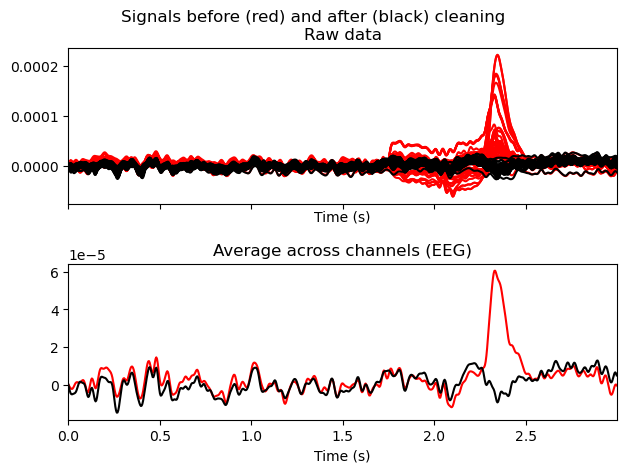

Channels marked as bad: ['Audio']


In [6]:
## WE NEED TO USE THE CUT FILE TO PERFORM ICA!!!

# set montage????? yes!!!
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
n_raw.set_montage(ten_twenty_montage, match_case=False)

# ICA
ica_ = ICA(n_components = 15, random_state=97)
ica_.fit(n_raw)

# plot ICA
#n_raw.plot_sensors(sphere = (0.0, 0.02, 0.0, 0.065))

# Exclude certain components
"""
S001:[0,5]  # DONE
S002:[0, 1, 3, 8, 10] #DONE
S003:[0,8,14] # DONE
S004-2:[0, 1, 3, 4, 6] #DONE
S005:[0, 1, 2, 8] #DONE
S006:[0,2]  #DONE >> adjust the filter range from 0-30 to 0.1-30
S007:[0,2]  #DONE >> adjust the filter range from 0-30 to 0.1-30
S008:[0,1,6,(7)]
"""

#ica_.plot_sources(n_raw)
#ica_.plot_components(sphere = (0.0, 0.02, 0.0, 0.065))  # What is this sphere for??
ica_.plot_overlay(n_raw, exclude=[0,2])

In [15]:
for i in range(15):
    #ica_.plot_properties(n_raw, picks=[i])
    ica_.plot_overlay(n_raw, exclude=[i])

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 57 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 57 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 57 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 57 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 57 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 57 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 I

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 57 PCA components


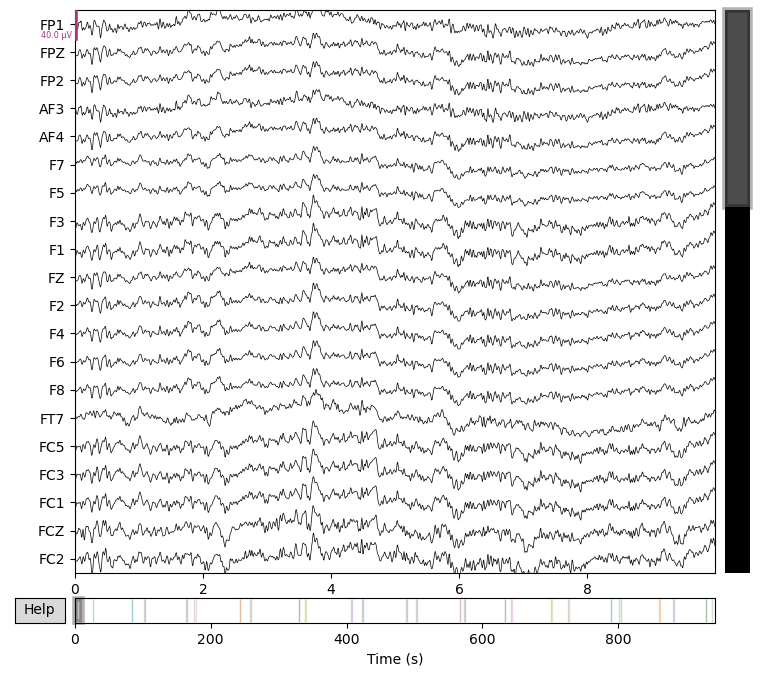

Channels marked as bad: none


In [7]:
#### What the hack is this?????

# This is the properties of each component
#ica_.plot_properties(n_raw, picks=[0, 1, 2, 3, 4, 5, 6, 7, 8])

# apply the cleaned ICA to the data 
ica_.exclude = [0,2]

raw_ICAed = n_raw.copy()
ica_.apply(raw_ICAed)
raw_ICAed.plot()

In [8]:
# Load in the csv file of word onset
#csv_data_path = "/Users/neuroling/Downloads/New_thesis/Ding-Thesis_ExpMaterials/"
csv_data_path = "/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Ding-Thesis_ExpMaterials/"
with open(csv_data_path + "AliceChapterOne-EEG.csv", "r", encoding="UTF-8") as f:
    fileLIST = f.read().split("\n")
    # the average of every word length is 0.2812(s) , approximately 300 ms
    
    word_onset_tapeLIST = []
    word_onset_allLIST = []
    tape_num_allLIST = []
    word_allLIST = []
    
    #exculde the header
    fileLIST.pop(0)
    print(len(fileLIST))
    
    
    for i in range(12):
        #print(i+1)
        word_onset_tapeLIST = []
        for row in fileLIST:    
            row = row.split(",")
            #print(row)
            #print(type(row))
            
            # some factors that are needed
            wordSTR = row[0]
            tape_numINT = int(row[1])
            word_onsetFLOAT = float(row[2])
            word_seqINT = int(row[10])
            sentence_seqINT = int(row[11])
            
            #print(sentence_seqINT)
            #print(type(sentence_seqINT))
            
            if tape_numINT == i+1:
                #print(wordSTR)
                
                word_onset_tapeLIST.append(word_onsetFLOAT)
            else:
                pass
        #pprint(word_onset_tapeLIST)
        print(len(word_onset_tapeLIST))
        word_onset_allLIST.append(word_onset_tapeLIST)
    #print(word_onset_allLIST)
    print(len(word_onset_allLIST))
    #for t in range(12):
        #print(len(word_onset_allLIST[t]))


2129
174
177
184
214
193
197
178
175
156
187
157
137
12


In [9]:
def correct_time(Start_timeFLOAT, End_timeFLOAT, stim_onsetFLOAT):
    '''
    to calculate the actual epoch start & end timepoints >>> Still need more calculation(NOT YET)
    
    Start_timeFLOAT = The timepoint of the segmented data start
    End_timeFLOAT = The timepoint of the segmented data end
    stim_onsetFLOAT = Every word onset timepoints
    '''
    actual_timeFLOAT = stim_onsetFLOAT*(End_timeFLOAT-Start_timeFLOAT)+(Start_timeFLOAT)
    return actual_timeFLOAT

def tpoints2sec(timepointsINT, sampling_rateINT):
    '''
    turn the timepoints to time (second, s) by divided by the sampling rate 
    >> mne.events_from_annotations(raw) >> event array[0]
    '''
    time_secFLOAT = timepointsINT/sampling_rateINT
    
    return time_secFLOAT
    

In [96]:
# Testing the tpoints2sec function

events = mne.events_from_annotations(raw_ICAed)
#print(events)

# covert the time points arrays into a list >> or is it better if we use it as the array??
trigger_tPointsNDArray = events[0]  #.tolist()
#print(trigger_tPointsNDArray)  

# Save the start % end timepoints into ndarray respectively.  
start_tNDarray = trigger_tPointsNDArray[::4]
#print(start_tNDarray)
#print(type(start_tNDarray))

end_tNDarray = trigger_tPointsNDArray[1::4]
#print(end_tNDarray)
#print(type(end_tNDarray))
#print(len(end_tNDarray))


for k in range(12):
    start_tFLOAT = tpoints2sec(start_tNDarray[k][0], 250)
    end_tFLOAT = tpoints2sec(end_tNDarray[k][0], 250)
    print(start_tFLOAT)
    print(end_tFLOAT)


Used Annotations descriptions: ['1', '10', '11', '12', '2', '3', '4', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '7', '8', '9', '99']
26.288
84.3
102.952
163.964
178.932
242.944
259.98
329.992
339.668
406.68
423.992
488.004
504.08
567.096
574.824
632.836
643.4
701.412
727.324
789.336
803.152
860.16
881.928
928.936


In [10]:
trigger_tPointsNDArray, event_idDICT = mne.events_from_annotations(raw_ICAed.copy())
#print(events)

# covert the time points arrays into a list >> or is it better if we use it as the array??
#trigger_tPointsNDArray = events[0]  #.tolist()
#print(trigger_tPointsNDArray)  

# Save the start % end timepoints into ndarray respectively.  
start_tNDarray = trigger_tPointsNDArray[::4]
print("Old start t points:",start_tNDarray)
#print(type(start_tNDarray))

end_tNDarray = trigger_tPointsNDArray[1::4]
print("Old end t points:",end_tNDarray)
#print(type(end_tNDarray))
print(len(end_tNDarray))


"""

### CONTINUE LATER ###
epoch_allLIST = []

# calculate the actual word onset by applying the min max scaling formula
for i in range(2):
    print(word_onset_allLIST[i])
    
    #start_tINT = start_tNDarray[i][0]
    #end_tINT = end_tNDarray[i][0]
    
    epoch_tapeLIST = []
    for onset_t in word_onset_allLIST[i]:
        start_tFLOAT = tpoints2sec(start_tNDarray[i][0], 250)
        end_tFLOAT = tpoints2sec(end_tNDarray[i][0], 250)
        
        epoch_onset = correct_time(start_tFLOAT, end_tFLOAT, onset_t)  #/1000
        #print(epoch_onset)        
        epoch_tapeLIST.append(epoch_onset)
    print(len(word_onset_allLIST[i]))
    #print(epoch_tapeLIST)
    print(len(epoch_tapeLIST))
    
    epoch_allLIST.append(epoch_tapeLIST)
print(epoch_allLIST)
print(len(epoch_allLIST))
"""

Used Annotations descriptions: ['1', '10', '11', '12', '2', '3', '4', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '7', '8', '9', '99']
Old start t points: [[  6572      0      1]
 [ 25738      0      5]
 [ 44733      0      6]
 [ 64995      0      7]
 [ 84917      0      8]
 [105998      0     19]
 [126020      0     22]
 [143706      0     23]
 [160850      0     24]
 [181831      0      2]
 [200788      0      3]
 [220482      0      4]]
Old end t points: [[ 21075      0     25]
 [ 40991      0     25]
 [ 60736      0     25]
 [ 82498      0     25]
 [101670      0     25]
 [122001      0     25]
 [141774      0     25]
 [158209      0     25]
 [175353      0     25]
 [197334      0     25]
 [215040      0     25]
 [232234      0     25]]
12


'\n\n### CONTINUE LATER ###\nepoch_allLIST = []\n\n# calculate the actual word onset by applying the min max scaling formula\nfor i in range(2):\n    print(word_onset_allLIST[i])\n    \n    #start_tINT = start_tNDarray[i][0]\n    #end_tINT = end_tNDarray[i][0]\n    \n    epoch_tapeLIST = []\n    for onset_t in word_onset_allLIST[i]:\n        start_tFLOAT = tpoints2sec(start_tNDarray[i][0], 250)\n        end_tFLOAT = tpoints2sec(end_tNDarray[i][0], 250)\n        \n        epoch_onset = correct_time(start_tFLOAT, end_tFLOAT, onset_t)  #/1000\n        #print(epoch_onset)        \n        epoch_tapeLIST.append(epoch_onset)\n    print(len(word_onset_allLIST[i]))\n    #print(epoch_tapeLIST)\n    print(len(epoch_tapeLIST))\n    \n    epoch_allLIST.append(epoch_tapeLIST)\nprint(epoch_allLIST)\nprint(len(epoch_allLIST))\n'

In [11]:
# Creating epochs (cutting into epochs so to speak)

epoch_allLIST = []

# To calculate the actual time for every word_onset, and save it down as a bug LIST
for i in range(12):
    #start_tFLOAT = tpoints2sec(start_tNDarray[i][0], 250)
    #end_tFLOAT = tpoints2sec(end_tNDarray[i][0], 250)
    #print(start_tFLOAT)
    #print(end_tFLOAT)        
    epoch_tapeLIST = []
    
    for onset_tFLOAT in word_onset_allLIST[i]:
        #print(type(onset_tFLOAT))
        
        start_tFLOAT = tpoints2sec(start_tNDarray[i][0], 250)
        end_tFLOAT = tpoints2sec(end_tNDarray[i][0], 250)
        
        epoch_onsetFLOAT = start_tFLOAT + onset_tFLOAT  #/1000
        #print(epoch_onsetFLOAT)
        
        epoch_tapeLIST.append(epoch_onsetFLOAT)

    #print(epoch_tapeLIST)
    #print(len(epoch_tapeLIST))
    
    epoch_allLIST.append(epoch_tapeLIST)
    
#print(epoch_allLIST)
#print(len(epoch_allLIST))


In [ ]:
def newTag4word_onsetARRAY(epoch_allLIST, sampling_rate)   #, loop_counts):  #, epoch_onsetFLOAT
    '''
    Turn the word onset time into a ndarray for further epoch dissection
    
    epoch_onsetFLOAT = Coverted word onset time based on the individual's raw data (in seconds)
    sampling_rate = The sampling rate of the current data
    #loop_counts = How many times do you want to repeat the procedure = the length of the epoch_allLIST
    '''
    #loop_counts = len
    
    for i in range(len(epoch_allLIST)):
    

In [151]:
def correct_time(Start_timeFLOAT, End_timeFLOAT, stim_onsetFLOAT):
    '''
    to calculate the actual epoch start & end timepoints >>> Still need more calculation(NOT YET)
    
    Start_timeFLOAT = The timepoint of the segmented data start
    End_timeFLOAT = The timepoint of the segmented data end
    stim_onsetFLOAT = Every word onset timepoints
    '''
    actual_timeFLOAT = stim_onsetFLOAT*(End_timeFLOAT-Start_timeFLOAT)+(Start_timeFLOAT)
    return actual_timeFLOAT

# (NOT YET)calculate a more precise datapoint for future epoch calculation
import math  # for 無條件進位

for i in range(12):
    min
    for onset_tFLOAT in word_onset_allLIST[i]:
        
        tmp_timeFLOAT = (word_onsetFLOAT-word_onset_minFLOAT)/(word_onset_maxFLOAT-word_onset_minFLOAT)
    actual_timeINT = math.ceil(tmp_timeFLOAT*trigger_dINT)

"""
for i in range(12):
    tape_tagINT = 26  # for the new event_idDICT's tag  i.e "tape1_word_onset":26 etc.
    for epoch_tFLOAT in epoch_allLIST[i]:
        epoch_tPointsINT = round((epoch_tFLOAT*250), 1)
        n_epoch_tPointsINT = math.ceil(epoch_tFLOAT*250)
        #print(epoch_tPointsINT)
        #print(n_epoch_tPointsINT)
        
        onset_tPointsLIST = [n_epoch_tPointsINT, 0, tape_tagINT]
        all_onset_tPointsLIST.append(onset_tPointsLIST)
all_onset_tPointsARRAY = np.array(all_onset_tPointsLIST)
"""

SyntaxError: expected ':' (2492082761.py, line 15)

In [12]:
# calculate the word onset datapoint
import math  # for 無條件進位

all_onset_tPointsLIST = []
for i in range(12):
    tape_tagINT = 26  # for the new event_idDICT's tag  i.e "tape1_word_onset":26 etc.
    for epoch_tFLOAT in epoch_allLIST[i]:
        epoch_tPointsINT = round((epoch_tFLOAT*250), 1)
        n_epoch_tPointsINT = math.ceil(epoch_tFLOAT*250)
        #print(epoch_tPointsINT)
        #print(n_epoch_tPointsINT)
        
        onset_tPointsLIST = [n_epoch_tPointsINT, 0, tape_tagINT]
        all_onset_tPointsLIST.append(onset_tPointsLIST)
all_onset_tPointsARRAY = np.array(all_onset_tPointsLIST)

print(all_onset_tPointsARRAY[:200])
#print(len(all_onset_tPointsARRAY))
print(all_onset_tPointsARRAY.shape)


[[ 6584     0    26]
 [ 6713     0    26]
 [ 6769     0    26]
 [ 6887     0    26]
 [ 6911     0    26]
 [ 6977     0    26]
 [ 7150     0    26]
 [ 7272     0    26]
 [ 7307     0    26]
 [ 7399     0    26]
 [ 7444     0    26]
 [ 7486     0    26]
 [ 7599     0    26]
 [ 7641     0    26]
 [ 7672     0    26]
 [ 7769     0    26]
 [ 7800     0    26]
 [ 7831     0    26]
 [ 7931     0    26]
 [ 8045     0    26]
 [ 8085     0    26]
 [ 8359     0    26]
 [ 8418     0    26]
 [ 8447     0    26]
 [ 8562     0    26]
 [ 8638     0    26]
 [ 8713     0    26]
 [ 8767     0    26]
 [ 8793     0    26]
 [ 8880     0    26]
 [ 8901     0    26]
 [ 9000     0    26]
 [ 9063     0    26]
 [ 9275     0    26]
 [ 9304     0    26]
 [ 9326     0    26]
 [ 9395     0    26]
 [ 9428     0    26]
 [ 9555     0    26]
 [ 9581     0    26]
 [ 9793     0    26]
 [ 9826     0    26]
 [10017     0    26]
 [10058     0    26]
 [10100     0    26]
 [10129     0    26]
 [10174     0    26]
 [10254     0

In [13]:
#event_idDICT = events[1]
pprint(event_idDICT)
# Copy the original event id, in case any irreversible changes happened
copied_event_idDICT = event_idDICT.copy()
#print(copied_event_idDICT)

# Set up the word onset tag's event_id DICT
"""
tape_word_onsetDICT = {'tape1_word_onset': 26,
                       'tape2_word_onset': 27,
                       'tape3_word_onset': 28,
                       'tape4_word_onset': 29,
                       'tape5_word_onset': 30,
                       'tape6_word_onset': 31,
                       'tape7_word_onset': 32,
                       'tape8_word_onset': 33,
                       'tape9_word_onset': 34,
                       'tape10_word_onset': 35,
                       'tape11_word_onset': 36,
                       'tape12_word_onset': 37}
                       """
tape_word_onsetDICT = {'tape_word_onset': 26}

# Combine the original event_idDICT with the word_onset tag DICT
copied_event_idDICT.update(tape_word_onsetDICT)
pprint(copied_event_idDICT)


{'1': 1,
 '10': 2,
 '11': 3,
 '12': 4,
 '2': 5,
 '3': 6,
 '4': 7,
 '5': 8,
 '50': 9,
 '51': 10,
 '52': 11,
 '53': 12,
 '54': 13,
 '55': 14,
 '56': 15,
 '57': 16,
 '58': 17,
 '59': 18,
 '6': 19,
 '60': 20,
 '61': 21,
 '7': 22,
 '8': 23,
 '9': 24,
 '99': 25}
{'1': 1,
 '10': 2,
 '11': 3,
 '12': 4,
 '2': 5,
 '3': 6,
 '4': 7,
 '5': 8,
 '50': 9,
 '51': 10,
 '52': 11,
 '53': 12,
 '54': 13,
 '55': 14,
 '56': 15,
 '57': 16,
 '58': 17,
 '59': 18,
 '6': 19,
 '60': 20,
 '61': 21,
 '7': 22,
 '8': 23,
 '9': 24,
 '99': 25,
 'tape_word_onset': 26}


In [14]:
# Create the epochs based on the new event id
"""
tmin = -0.5                                         # pre stimulis interval (in seconds) #
tmax = 1.0                                          # post stimulus interval #

picks = mne.pick_types(raw_.info, eeg= True, stim = False)    # channels to use in epochs #
baseline = (-0.1, 0)      
reject_ = dict(eeg=100e-6) # eeg: V, meg: T                                                       # what to use as baseline comparison - here it's pre-stim interval #
epochs = mne.Epochs(raw_clean, new_events, event_id, tmin, tmax, proj = True,
                    picks = picks, baseline=baseline,
                    reject = reject_, preload = True)
"""

new_event_idDICT = tape_word_onsetDICT  #copied_event_idDICT
tmin = -0.1      # pre stimulis interval (in second) #
tmax = 0.5       # post stimulus interval (in second) # 

picks = mne.pick_types(raw_ICAed.copy().info, eeg= True, stim = False)    # channels to use in epochs #
baseline = (-0.1, 0)      
reject_ = dict(eeg=100e-6) # eeg: V, meg: T                                                       # what to use as baseline comparison - here it's pre-stim interval #
epochs = mne.Epochs(raw_ICAed.copy(), all_onset_tPointsARRAY, new_event_idDICT, tmin, tmax, proj=True,
                    picks=picks, baseline=baseline,
                    reject=reject_, preload=True)   #reject = reject_ original
        

Not setting metadata
Not setting metadata
2129 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 2129 events and 151 original time points ...
0 bad epochs dropped


In [17]:
# plotting the epochs based on each word onset in every tape
"""
# evoked based on each tape
for tapeINT in range(12):
    tape_evoked = epochs['tape%s_word_onset' %str(tapeINT+1)].average().apply_baseline((-0.1, 0)).pick_types(eeg= True, stim = False).crop(-0.1, 0.5 )
    tape_evoked.plot_topo()
"""
# evoked of every word
tape_evoked = epochs['tape_word_onset'].average().apply_baseline((-0.1, 0)).pick_types(eeg= True, stim = False).crop(-0.1, 0.5)
tape_evoked.plot()
#tape_evoked.plot_topo()
#tape_evoked.plot_topomap()

    
    
"""
# Make a comparison
tmp = [std_evoked, devL_evoked, devS_evoked]
colors = 'red', 'blue', 'green'
#mne.viz.plot_evoked_topo(tmp, color = colors, title = 'MMN', ylim = dict(eeg=[10, -10]))
mne.viz.plot_compare_evokeds(tmp, colors = colors, axes = 'topo')
"""

Applying baseline correction (mode: mean)


"\n# Make a comparison\ntmp = [std_evoked, devL_evoked, devS_evoked]\ncolors = 'red', 'blue', 'green'\n#mne.viz.plot_evoked_topo(tmp, color = colors, title = 'MMN', ylim = dict(eeg=[10, -10]))\nmne.viz.plot_compare_evokeds(tmp, colors = colors, axes = 'topo')\n"

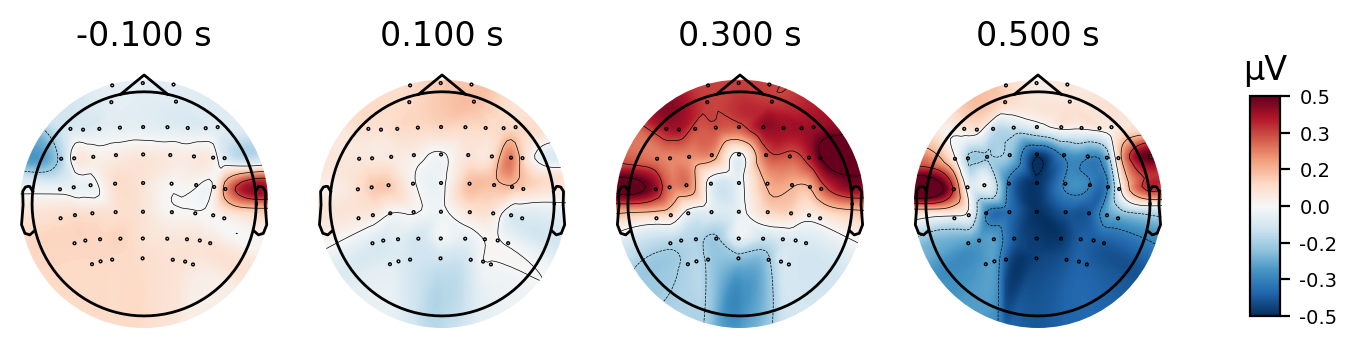

In [148]:
tape_evoked.plot_topomap()

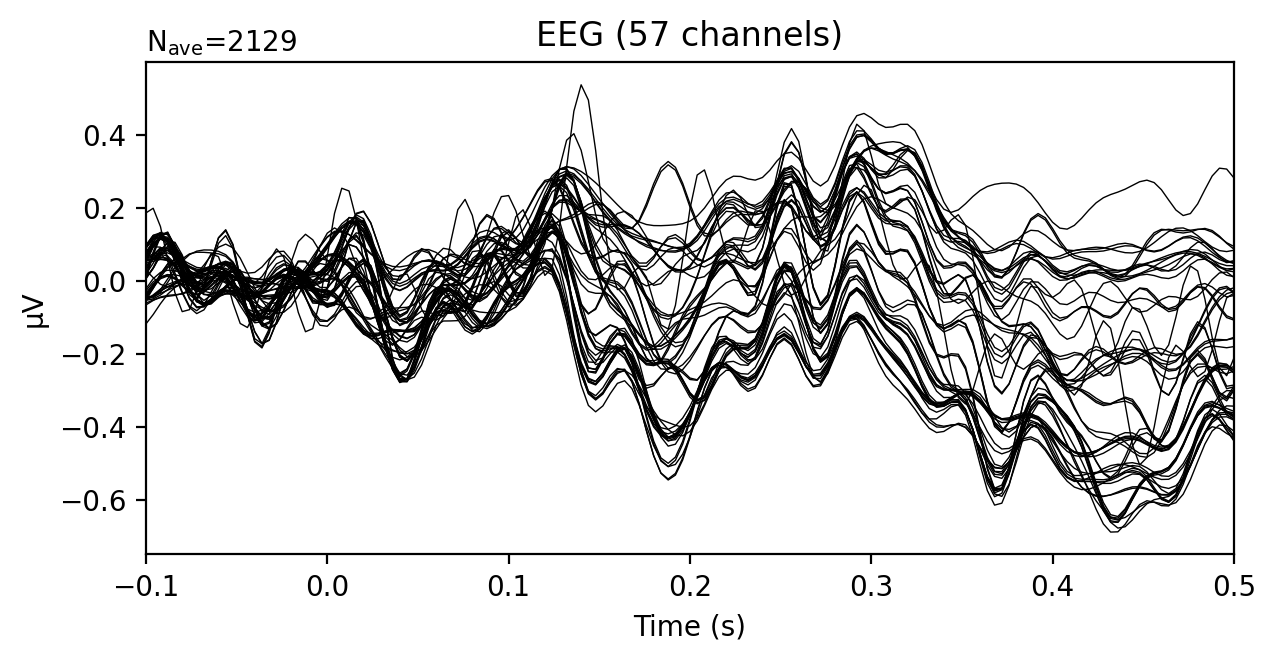

In [150]:
tape_evoked.plot()

## Below are the old codes

In [ ]:
# Use the event id >> should segment the data first??
event_id = {'1': 1, '10': 2, '11': 3, '12': 4, '2': 5, '3': 6, '4': 7, '5': 8, '6': 9, '7': 10, '8': 11, '9': 12, '99': 13}
#{'1': 1, '10': 2, '11': 3, '12': 4, '2': 5, '3': 6, '4': 7, '5': 8, '6': 9, '7': 10, '8': 11, '9': 12, '99': 13}
                                        # state which conditions match with which triggers #

# each epoch would be 300 ms long 
# >> start_timepoint = each onset, end_timepoint = onset + 0.3 
# need to recalibrate the starting time point in every part of 
tmin = -0.5                                         # pre stimulis interval (in seconds) #
tmax = 1.0                                          # post stimulus interval #

picks = mne.pick_types(raw_.info, eeg= True, stim = False)    # channels to use in epochs #
baseline = (-0.1, 0)      
reject_ = dict(eeg=100e-6) # eeg: V, meg: T                                                       # what to use as baseline comparison - here it's pre-stim interval #
epochs = mne.Epochs(raw_clean, new_events, event_id, tmin, tmax, proj = True,
                    picks = picks, baseline=baseline,
                    reject = reject_, preload = True)

In [ ]:
# see the average of the epochs, I think

std_evoked = epochs['Standard (yi3)'].average().apply_baseline((-0.1, 0)).pick_types(eeg= True, stim = False).crop(-0.1, 0.7)
devL_evoked = epochs['Large deviant (yi1)'].average().apply_baseline((-0.1, 0)).pick_types(eeg= True, stim = False).crop(-0.1, 0.7)
devS_evoked = epochs['Small deviant (yi2)'].average().apply_baseline((-0.1, 0)).pick_types(eeg= True, stim = False).crop(-0.1, 0.7)

print(std_evoked)
print(devL_evoked)
print(devS_evoked)

In [22]:
# OLD VERSION OF CUTTING THE FILES

# List out the triggers #the starting and ending time point for each tape #時間要除以1000=事件發生的時間點
events = mne.events_from_annotations(raw_ICAed)
#print(events)

# covert the time points arrays into a list >> or is it better if we use it as the array??
trigger_tPointsNDArray = events[0]  #.tolist()
#print(trigger_tPointsNDArray)  

"""
dict.keys()
dict.values()
dict.items()

triggerLIST = list(range(1,13))
#print(triggerLIST)

trigger_nameDICT = events[1]
triggerkey = trigger_nameDICT.keys()
trigger_nameDICT.keys()    # the actual number mark I made for trigger
print(trigger_nameDICT.values())  # 1-25
"""

# Save the start % end timepoints into ndarray respectively.  
start_tNDarray = trigger_tPointsNDArray[::4]
print(start_tNDarray)
#print(type(start_tNDarray))
end_tNDarray = trigger_tPointsNDArray[1::4]
print(end_tNDarray)
#print(type(end_tNDarray))
print(len(end_tNDarray))

save_data_path = "/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S007_cut/"
"""
# cut the data by the timepoints
for i in range(12):
    # timepoint is in ms! (%1000 when needs to see in minute)
    start_t = start_tNDarray[i][0]/1000
    end_t = end_tNDarray[i][0]/1000
    print("start at", start_t, ";", "ends at", end_t)
    
    # cut the parts by the start & end timepoints (= save as each tapes)
    cut_file = raw_ICAed.copy().crop(tmin = start_t, tmax= end_t)
    cut_file.save(save_data_path + "S007-Alice_{}cut.fif".format(i+1), overwrite = True)
    print("DONE")
print("ALL DONE")
"""

Used Annotations descriptions: ['1', '10', '11', '12', '2', '3', '4', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '7', '8', '9', '99']
[[  6572      0      1]
 [ 25738      0      5]
 [ 44733      0      6]
 [ 64995      0      7]
 [ 84917      0      8]
 [105998      0     19]
 [126020      0     22]
 [143706      0     23]
 [160850      0     24]
 [181831      0      2]
 [200788      0      3]
 [220482      0      4]]
[[ 21075      0     25]
 [ 40991      0     25]
 [ 60736      0     25]
 [ 82498      0     25]
 [101670      0     25]
 [122001      0     25]
 [141774      0     25]
 [158209      0     25]
 [175353      0     25]
 [197334      0     25]
 [215040      0     25]
 [232234      0     25]]
12


'\n# cut the data by the timepoints\nfor i in range(12):\n    # timepoint is in ms! (%1000 when needs to see in minute)\n    start_t = start_tNDarray[i][0]/1000\n    end_t = end_tNDarray[i][0]/1000\n    print("start at", start_t, ";", "ends at", end_t)\n    \n    # cut the parts by the start & end timepoints (= save as each tapes)\n    cut_file = raw_ICAed.copy().crop(tmin = start_t, tmax= end_t)\n    cut_file.save(save_data_path + "S007-Alice_{}cut.fif".format(i+1), overwrite = True)\n    print("DONE")\nprint("ALL DONE")\n'

In [ ]:
tmp = [std_evoked, devL_evoked, devS_evoked]
colors = 'red', 'blue', 'green'
#mne.viz.plot_evoked_topo(tmp, color = colors, title = 'MMN', ylim = dict(eeg=[10, -10]))
mne.viz.plot_compare_evokeds(tmp, colors = colors, axes = 'topo')